# DESCRIPCIÓN

La idea principal es entrenar un modelo a travez de una red neuronal convolucional multitaréa para clasificación y regresión, desarrollaremos un modelo convolucional que dada una imagen con un rostro, lograr identificar el genero, etnia y predecir la edad aproximada de la persona en la foto.

* identificación de genero (clasificacion)
* identificacion de etnia (clasificación)
* predicción de la edad (regresión)

conjunto de datos.

https://susanqq.github.io/UTKFace/

el conjunto de datos utilizado es un dataset con aproximadamente 23000 imagenes de personas con distintas edades, genero y etnias.

In [6]:
# IMPORTAR LIBRERIAS NECESARIAS
#==========================================================================#
import numpy as np
from skimage import io
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Input, Dropout, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from IPython.display import Image
from IPython.display import clear_output
from keras.callbacks import CSVLogger
from tensorflow.keras.utils import plot_model

### CARGAR IMAGENES

dataset con la ruta de las imagenes, previamente se proceso para extraer las etiquetas necesarias.
* genero
* etnia
* edad

In [2]:
data = pd.read_csv('data_images.csv')

In [5]:
# DIVIENDO DATASET Y GUARDAR X_TEST PARA VALIDACIÓN POSTERIOR DEL MODELO
#================================================================================#

X_train, X_test = train_test_split(data,test_size=0.15,random_state=0)

df_test = pd.DataFrame(X_test)
df_test.to_csv('text_images.csv',index=False)

### Experimentacion con dimensiones de la imagen

experimentación con dimensiones de la imagen, probando distintutas dimensiones.
los resultados fueron muy similares

In [7]:
#img_height = 100
#img_width = 100

#probando con 200
img_height = 200
img_width = 200
batch_size = 32

### Creando modelo

### Multitasking Learning

El aprendizaje multitarea es un enfoque de la transferencia inductiva que mejora la generalización mediante el uso de la información de dominio contenida en las señales de entrenamiento de las tareas relacionadas como un sesgo inductivo. Lo hace aprendiendo tareas en paralelo mientras utiliza una representación compartida; lo que se aprende para cada tarea puede ayudar a que otras tareas se aprendan mejor.

El modelo entrenado, sera para 3 tareas especificas, 2 de clasificación y una de regresión..
Basado en una imagen predecir:
 * El genero de la persona (male, female): **classificación**
 * La etnia ('white','black','asian','indian','others'): **classificación**
 * La edad: **regresión**

In [8]:
#DEFINIENDO RED Y PARAMETROS DE LAS CAPAS
#================================================================================#
filter_size = (3, 3)
maxpool_size = (2, 2)
dr = 0.3

#entrada de la red con las dimensiones de la imagen
inputs = Input(shape=(img_width,img_height,3), name='main_input')

#capa principal de la red convolucional, con 16 filtros de 3x3
main_branch = Conv2D(16, kernel_size=filter_size, padding="same")(inputs)

#agregamos función de activación relu
main_branch = Activation("relu")(main_branch)

#capa maxpooling para redimensionar la imagen al a mitad por el maxpooling 2x2
main_branch = MaxPooling2D(pool_size=maxpool_size)(main_branch)

#segunda capa convolucional con 32 filtros de 3 x 3
main_branch = Conv2D(32, kernel_size=filter_size, padding="same")(main_branch)

#función de activacion relu
main_branch = Activation("relu")(main_branch)

#segunda capa de maxpoolin 2x2
main_branch = MaxPooling2D(pool_size=maxpool_size)(main_branch)

#tercera capa convolucional on 64 filtros de 3x3
main_branch = Conv2D(64, kernel_size=filter_size, padding="same")(main_branch)

#función de activación relu
main_branch = Activation("relu")(main_branch)

#tercera capa de maxpoolin de 2x2
main_branch = MaxPooling2D(pool_size=maxpool_size)(main_branch)

#aplanamos la matriz de las imagenes a un vector
main_branch = Flatten()(main_branch)

#agregamos capa dense con 512 neuronas
main_branch = Dense(512)(main_branch)

#función de activación relu
main_branch = Activation('relu')(main_branch)

#desactivamos el 50% de las 512 neuronas agregadas
main_branch = Dropout(0.5)(main_branch)

#DEFINIMOS LAS SALIDAS DE LA RED
#clasificación de genero, capa dense con función de activación softmax (2 tipos)
gender_branch = Dense(2, activation='softmax', name='gender_output')(main_branch)

#clasificación de etnia con función de activación softmax (5 tipos)
race_branch = Dense(5, activation='softmax', name='race_output')(main_branch)

#predición de la edad con la función de activación linear ya que necesitamos la salida tal y como viene
age_branch = Dense(1, activation='linear', name='age_output')(main_branch)

In [9]:
#agregamos al modelo la entrada y salidas respectivamente
model = Model(inputs = inputs,
     outputs = [gender_branch,race_branch, age_branch])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 200, 200, 16) 448         main_input[0][0]                 
__________________________________________________________________________________________________
activation (Activation)         (None, 200, 200, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 100, 100, 16) 0           activation[0][0]                 
______________________________________________________________________________________________

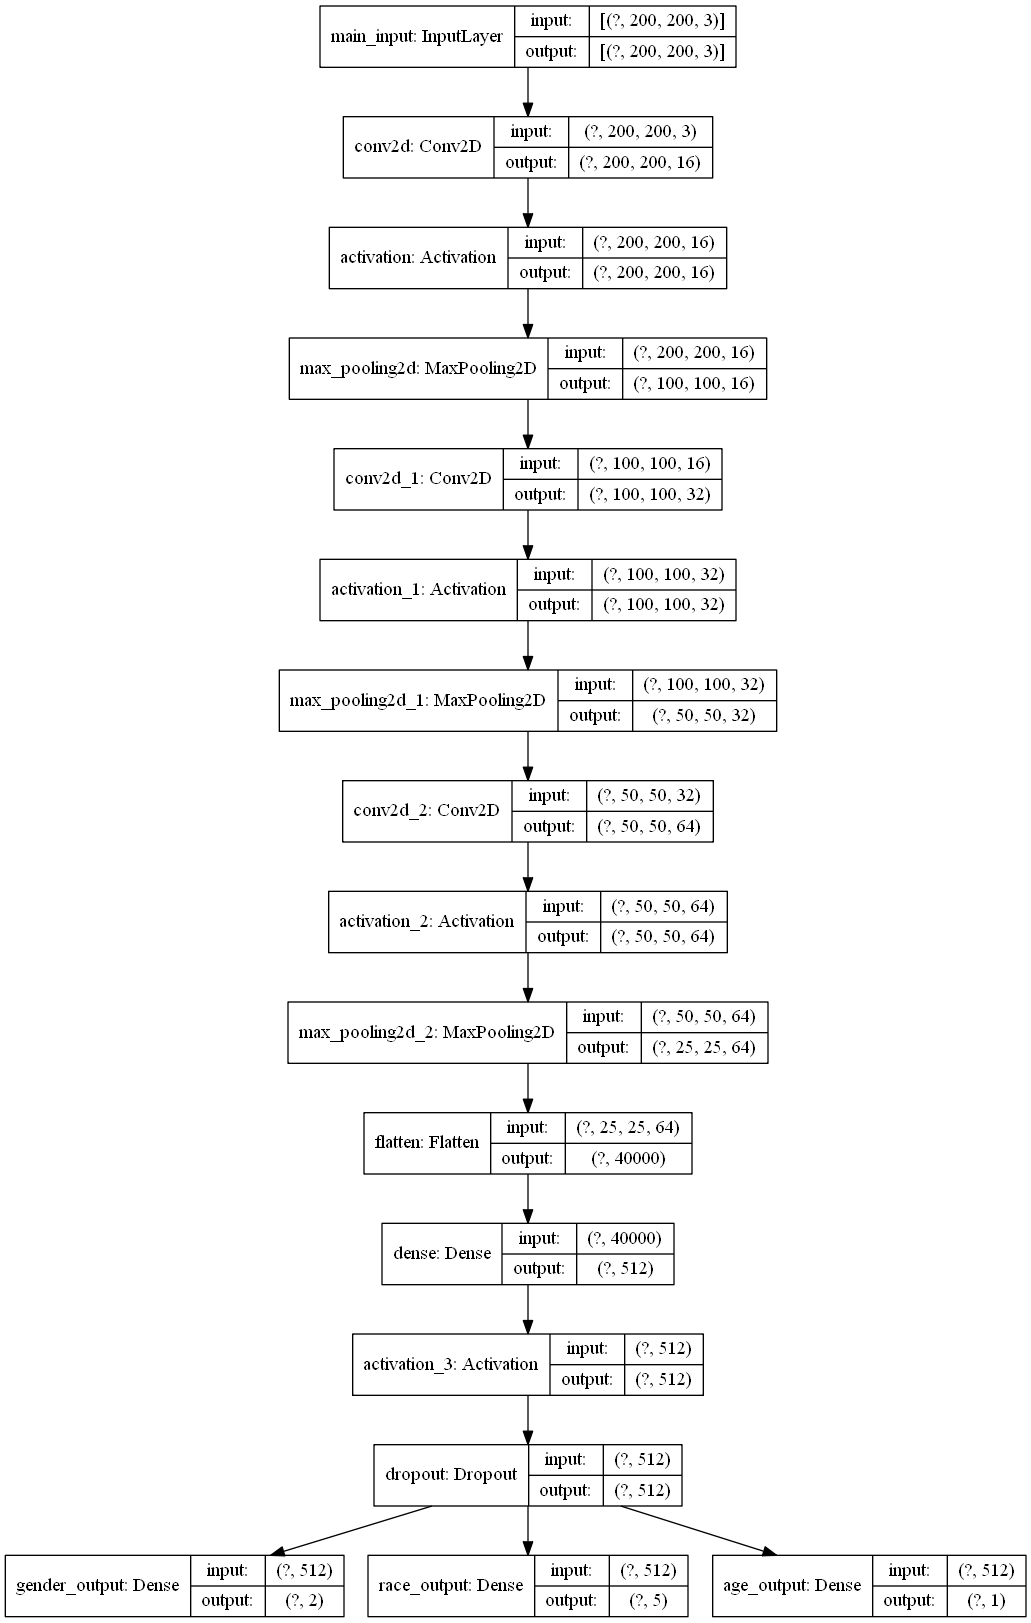

In [10]:
from keras.utils import plot_model
plot_model(model, to_file='cnn_model.png', show_shapes=True, show_layer_names=True)

In [367]:
model.compile(optimizer = Adam(lr = 0.001),
             loss = {'gender_output': "sparse_categorical_crossentropy", 'race_output': "sparse_categorical_crossentropy", 'age_output': "mse"},
             loss_weights={'gender_output': 1., 'race_output': 1., 'age_output': .001},
             metrics={'gender_output': 'accuracy', 'race_output': 'accuracy', 'age_output':'mse'})

## PREPROCESAMIENTO DE IMAGENES

Extraer las imagenes del directorio por medio del dataset de rutas cargado previamentes, usando la función de keras, ImageDataGenerator que nos permite normalizar las imagenes ademas de otras caracteristicas, como hacer zoom a imagenes de forma aletaria, cargar las imagenes por lotes y no saturar la memoria del computador, etc.

In [368]:
#CARGANDO IMAGENES DEL DIRECTORIO
#=====================================================================================#
path = '../UTKFace/'

#columnas del dataset
columns=["gender", "race", "age"]

#configurando imagedatagenerator
datagen = ImageDataGenerator(rescale=1./255.,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True,
                                 validation_split=0.15)

#dataset de entranamiento
train_generator=datagen.flow_from_dataframe(
    dataframe=X_train,
    directory=path,
    x_col="path",
    y_col=columns,
    subset="training",
    batch_size=batch_size,
    #seed=42,
    shuffle=True,
    class_mode="raw",
    color_mode="rgb",
    target_size=(img_height,img_width)
)


#dataset para validación en momento de entranamiento
valid_generator=datagen.flow_from_dataframe(
    dataframe=X_train,
    directory=path,
    x_col="path",
    y_col=columns,
    subset="validation",
    batch_size=batch_size,
    #seed=42,
    shuffle=True,
    class_mode="raw",
    color_mode="rgb",
    target_size=(img_height,img_width)
)


#dataset de pruebas
test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
    dataframe=X_test,
    directory='../UTKFace/',
    x_col="path",
    y_col=columns,
    batch_size=batch_size,
    class_mode="raw",
    color_mode="rgb",
    target_size=(img_height,img_width)
)


Found 17129 validated image filenames.
Found 3022 validated image filenames.
Found 3557 validated image filenames.


## GUARDAR MODELO
El modelo se guarda por cada iteración, entotal fueron 5 experimentos realizados

* experimento 1
* experimento 2
* experimento 3
* experimento 4
* experimento 5 (actual)

In [370]:
#GUARDAMOS MODELO POR CADA ITERACIÓN
#=======================================================================================#
filepath = 'checkpoints\experimento5\cp-class{epoch:02d}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1,
    save_best_only=False, mode='auto', save_freq='epoch')

In [371]:
#OBTENEMOS LAS ETIQUETAS PARA LAS DISTITAS SALIDAS DE LA RED
#===========================================================================================#

def generator_wrapper(generator):
    for batch_x,batch_y in generator:
        yield (batch_x,[batch_y[:,i] for i in range(3)])

### Experimento # 1

datos de la red del experimento 1 (unicamente se incluyó este experimento), los resultados de los demas fueron muy similares.

filter_size = (5, 5)
maxpool_size = (2, 2)
dr = 0.3

* inputs = Input(shape=(100,100,3), name='main_input')

* main_branch = Conv2D(16, kernel_size=filter_size, padding="same")(inputs)
* main_branch = Activation("relu")(main_branch)
* main_branch = MaxPooling2D(pool_size=maxpool_size)(main_branch)
* main_branch = Dropout(dr)(main_branch)

* main_branch = Conv2D(8, kernel_size=filter_size, padding="same")(main_branch)
* main_branch = Activation("relu")(main_branch)
* main_branch = MaxPooling2D(pool_size=maxpool_size)(main_branch)
* main_branch = Dropout(dr)(main_branch)

* main_branch = Flatten()(main_branch)
* main_branch = Dense(32)(main_branch)
* main_branch = Activation('relu')(main_branch)
* main_branch = Dropout(dr)(main_branch)



* model.compile(optimizer = Adam(lr = 0.001),
  *           loss = {'gender_output': "binary_crossentropy", 'race_output': "binary_crossentropy", 'age_output': "mse"},
   *          metrics={'gender_output': 'accuracy', 'race_output': 'accuracy', 'age_output':'mse'})
   
 Resultados.
 * Acc entrenamiento gender = 0.37
 * Acc validacion gender = 0.25
 * Acc entranamiento = 0.14
 * Acc validacion = 0.13
 
 Los resultados de esta primer experimento son bastante malos.

Nota: El cambio del experimento 2 al 3 y 5 unicamente consistió en cambio de datos de validacion y test mas las dimensiones de las imagenes

In [372]:
#ENTRENAMIENTO DE LA RED

#numero de iteraciones
nb_epochs = 20

#guardar historial del entrenamiento por cada iteracion
csv_logger = CSVLogger("checkpoints/experimento5/model_history_log.csv", append=True)

#parametros necesarios
STEP_SIZE_TRAIN=train_generator.n//batch_size
STEP_SIZE_VALID=valid_generator.n//batch_size
STEP_SIZE_TEST=test_generator.n//batch_size

history = model.fit(generator=generator_wrapper(train_generator),
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=generator_wrapper(valid_generator),
                    validation_steps=STEP_SIZE_VALID,
                    epochs=nb_epochs,
                    verbose=1,
                    callbacks=[checkpoint, csv_logger])

Epoch 1/20
535/535 [==============================] - ETA: 0s - loss: 2.2207 - gender_output_loss: 0.5220 - race_output_loss: 1.2500 - age_output_loss: 448.6624 - gender_output_accuracy: 0.7366 - race_output_accuracy: 0.5227 - age_output_mse: 448.6624
Epoch 00001: saving model to checkpoints\experimento5\cp-class01.hdf5
535/535 [==============================] - 883s 2s/step - loss: 2.2207 - gender_output_loss: 0.5220 - race_output_loss: 1.2500 - age_output_loss: 448.6624 - gender_output_accuracy: 0.7366 - race_output_accuracy: 0.5227 - age_output_mse: 448.6624 - val_loss: 1.5235 - val_gender_output_loss: 0.3626 - val_race_output_loss: 0.9218 - val_age_output_loss: 239.1138 - val_gender_output_accuracy: 0.8358 - val_race_output_accuracy: 0.6503 - val_age_output_mse: 239.1138
Epoch 2/20
535/535 [==============================] - ETA: 0s - loss: 1.5883 - gender_output_loss: 0.3929 - race_output_loss: 0.9450 - age_output_loss: 250.3955 - gender_output_accuracy: 0.8204 - race_output_accura

Epoch 12/20
535/535 [==============================] - ETA: 0s - loss: 1.0273 - gender_output_loss: 0.2497 - race_output_loss: 0.6215 - age_output_loss: 156.1765 - gender_output_accuracy: 0.8920 - race_output_accuracy: 0.7847 - age_output_mse: 156.1765
Epoch 00012: saving model to checkpoints\experimento5\cp-class12.hdf5
535/535 [==============================] - 1047s 2s/step - loss: 1.0273 - gender_output_loss: 0.2497 - race_output_loss: 0.6215 - age_output_loss: 156.1765 - gender_output_accuracy: 0.8920 - race_output_accuracy: 0.7847 - age_output_mse: 156.1765 - val_loss: 1.0055 - val_gender_output_loss: 0.2639 - val_race_output_loss: 0.6144 - val_age_output_loss: 127.2146 - val_gender_output_accuracy: 0.8803 - val_race_output_accuracy: 0.7859 - val_age_output_mse: 127.2146
Epoch 13/20
535/535 [==============================] - ETA: 0s - loss: 1.0139 - gender_output_loss: 0.2439 - race_output_loss: 0.6143 - age_output_loss: 155.6839 - gender_output_accuracy: 0.8937 - race_output_acc

In [373]:
# Obtener metricas para datos de prueba
#============================================================#

load_model_20 = load_model('checkpoints/experimento5/cp-class20.hdf5')

preds = []
for i in range(0,112):
    pr = load_model_20.predict(test_generator[i][0])
    preds.append(pr)

In [374]:
#GUARDAR LAS PREDICCIONES DE LAS DIFERENTES SALIDAS
#===================================================================================#

gender_preds = []
race_preds = []
age_preds = []

for p in preds:
    gender_p = list(np.argmax(p[0], axis=1))
    race_p = list(np.argmax(p[1], axis=1))
    age_p = list((p[2]).astype(int))
    
    gender_preds= gender_preds + gender_p
    race_preds=race_preds + race_p
    age_preds=age_preds + age_p

In [375]:
#IMPORT METRICS PARA EVALUACIÓN
from sklearn import metrics

y_test = []
for j in range(0,112):
    y_test+=list(test_generator[j][1])
y_test = np.array(y_test)

In [376]:
#IMPRIMIENDO METRICAS.
#=======================================================================================#
print('accuracy gender', metrics.accuracy_score(y_test[:,0], np.array(gender_preds)))
print('accuracy race', metrics.accuracy_score(y_test[:,1], np.array(race_preds)))
print('r2 age', metrics.r2_score(y_test[:,2], np.array(age_preds)))

accuracy gender 0.9125667697497891
accuracy race 0.8079842563958392
r2 age 0.7320947762806369


In [382]:
#REPORTE DE SALIDAS DE CLASIFICACION
#===========================================================================================#

print("Report Gender")
print(metrics.classification_report(y_test[:,0], np.array(gender_preds)))

print("Report Race")
print(metrics.classification_report(y_test[:,1], np.array(race_preds)))

Report Gender
              precision    recall  f1-score   support

           0       0.92      0.91      0.91      1824
           1       0.91      0.91      0.91      1733

    accuracy                           0.91      3557
   macro avg       0.91      0.91      0.91      3557
weighted avg       0.91      0.91      0.91      3557

Report Race
              precision    recall  f1-score   support

           0       0.79      0.94      0.86      1451
           1       0.84      0.90      0.87       715
           2       0.86      0.85      0.85       515
           3       0.80      0.68      0.73       618
           4       0.47      0.08      0.14       258

    accuracy                           0.81      3557
   macro avg       0.75      0.69      0.69      3557
weighted avg       0.79      0.81      0.78      3557



### Resultados (Modelo aceptado)

* gender_output_loss: 0.2190 - race_output_loss: 0.5404 - age_output_loss: 145.9898 -
* gender_output_accuracy: 0.9088 -   race_output_accuracy: 0.8130 - age_output_mse: 145.9898 - 
* val_loss: 0.9082 - val_gender_output_loss: 0.2065 - val_race_output_loss: 0.5905 - val_age_output_loss: 111.1718 - 
* val_gender_output_accuracy: 0.9102 - val_race_output_accuracy: 0.7969 - val_age_output_mse: 111.1718

Se observa en los resultados del reporte, que para la clasificacion de genero el modelo aprendió bastante bien.
Para race, no predice bien al label (otros), esto se debe a la poca data existe para indentificar otra etnia.

En la edad el modelo explica el 73%.

Resultados aceptables. la exactitud de entrenamiento y validación para ambos modelos de clasificacion, para el modelo de regresión obtenemos un mse de 145.98, converge bastante bien.

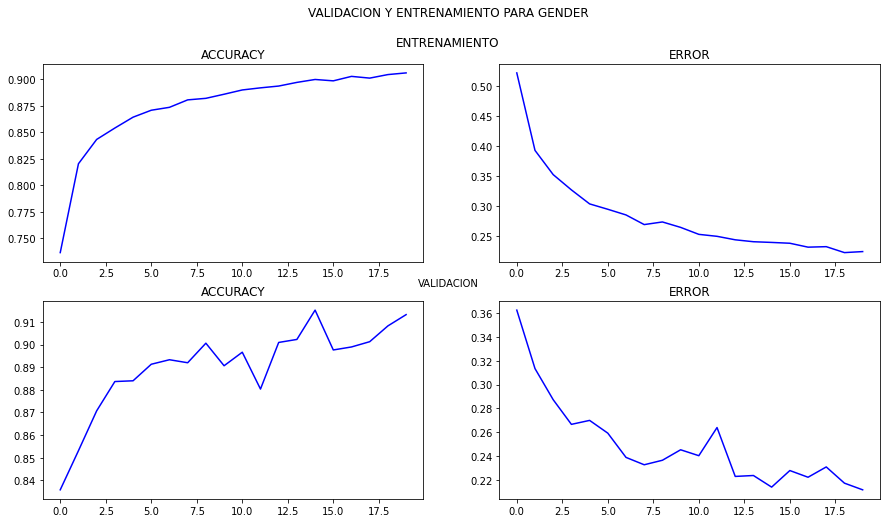

In [384]:
#GRAFICANDO ACCURACY Y ERROR EN ENTRENAMIENTO Y VALIDACION
#================================================================#

acc = history.history['gender_output_accuracy']
loss = history.history['gender_output_loss']

acc_v = history.history['val_gender_output_accuracy']
loss_v = history.history['val_gender_output_loss']

epochs = range(len(acc))

f, (ax1, ax2) = plt.subplots(2, 2, figsize=(15,8))

plt.suptitle('VALIDACION Y ENTRENAMIENTO PARA GENDER\n\nENTRENAMIENTO')

ax1[0].set_title("ACCURACY")
ax1[1].set_title("ERROR")
ax1[0].plot(epochs, acc, 'b', label="Accuracy entrenamiento")
ax1[1].plot(epochs, loss, 'b', label="Error de entrenamiento")


plt.figtext(0.5, 0.5, 'VALIDACION', ha='center', va='center')

ax2[0].set_title("ACCURACY")
ax2[1].set_title("ERROR")
ax2[0].plot(epochs, acc_v, 'b', label="Accuracy validación")
ax2[1].plot(epochs, loss_v, 'b', label="Error de validación")

plt.show()

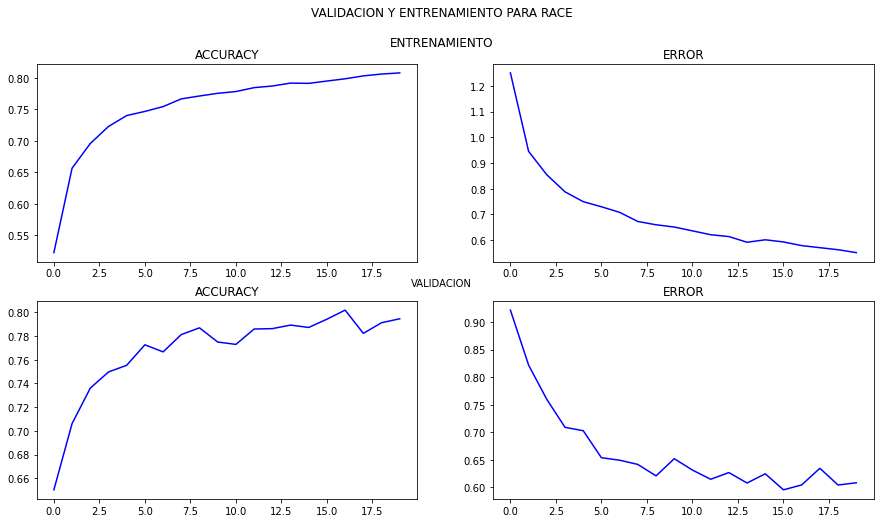

In [385]:
acc = history.history['race_output_accuracy']
loss = history.history['race_output_loss']

acc_v = history.history['val_race_output_accuracy']
loss_v = history.history['val_race_output_loss']

epochs = range(len(acc))

f, (ax1, ax2) = plt.subplots(2, 2, figsize=(15,8))

plt.suptitle('VALIDACION Y ENTRENAMIENTO PARA RACE\n\nENTRENAMIENTO')

ax1[0].set_title("ACCURACY")
ax1[1].set_title("ERROR")
ax1[0].plot(epochs, acc, 'b', label="Accuracy entrenamiento")
ax1[1].plot(epochs, loss, 'b', label="Error de entrenamiento")


plt.figtext(0.5, 0.5, 'VALIDACION', ha='center', va='center')

ax2[0].set_title("ACCURACY")
ax2[1].set_title("ERROR")
ax2[0].plot(epochs, acc_v, 'b', label="Accuracy validación")
ax2[1].plot(epochs, loss_v, 'b', label="Error de validación")

plt.show()

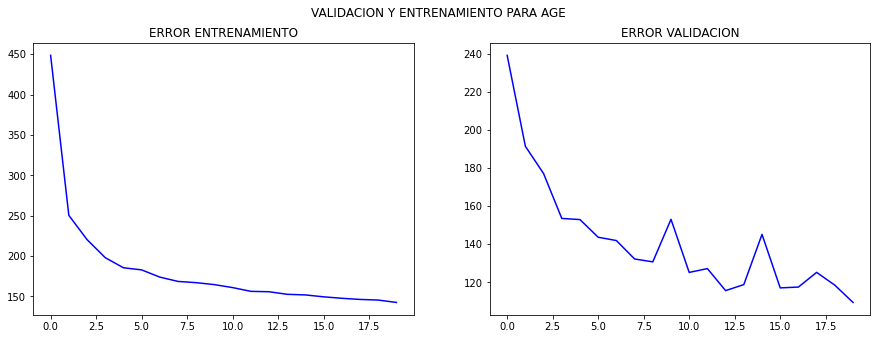

In [386]:
loss = history.history['age_output_loss']

loss_v = history.history['val_age_output_loss']

epochs = range(len(acc))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

plt.suptitle('VALIDACION Y ENTRENAMIENTO PARA AGE')

ax1.set_title("ERROR ENTRENAMIENTO")
ax2.set_title("ERROR VALIDACION")
ax1.plot(epochs, loss, 'b', label="Accuracy entrenamiento")
ax2.plot(epochs, loss_v, 'b', label="Error de entrenamiento")

plt.show()

### Graficar representaciones intermedias

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


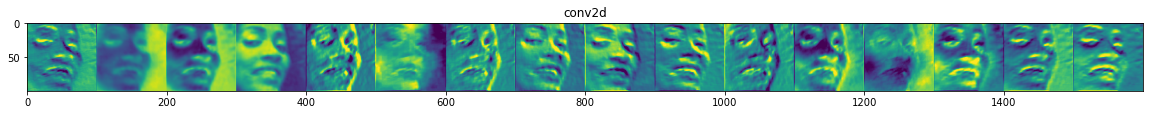

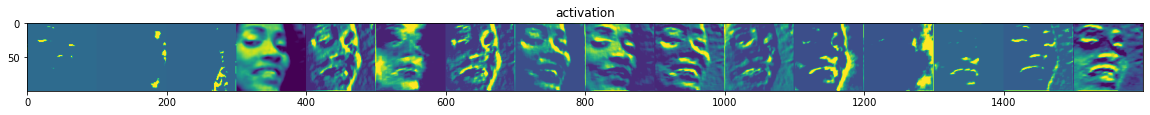

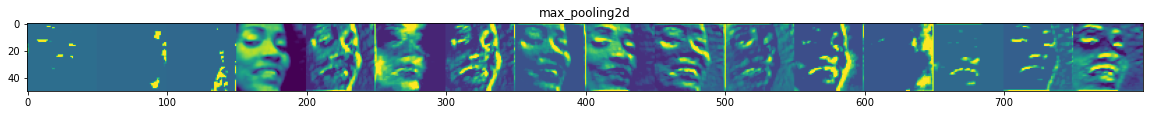

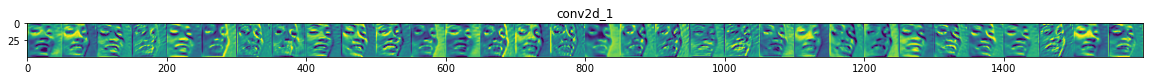

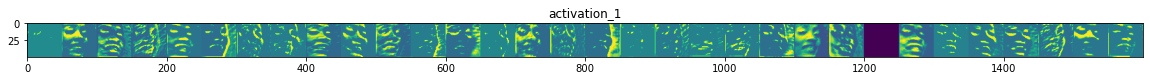

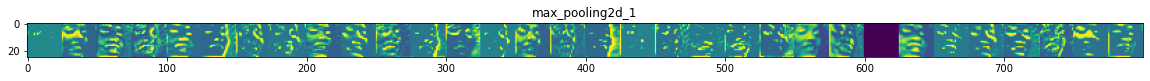

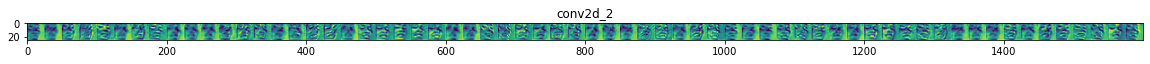

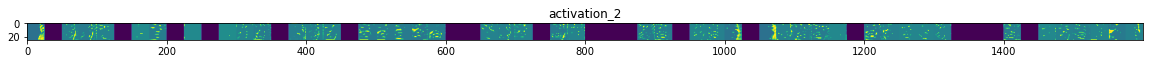

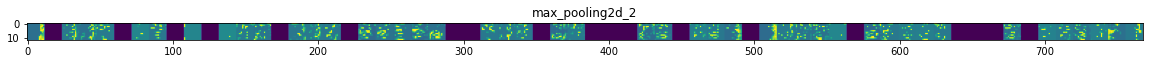

In [363]:
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

successive_outputs = [layer.output for layer in load_model_20.layers[1:]]

visualization_model = tf.keras.models.Model(inputs = load_model_20.input, outputs = successive_outputs)

path = '../UTKFace/'

img_path = random.choice(np.array(X_train['path']))

img_path = path+'/'+img_path

img = load_img(img_path, target_size=(100, 100))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)


# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers[1:]]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

### Otros experimentos

In [150]:
#segundo experimento agregar una capa convulucional extra de 64 filtros
#agregar 512 a la ultima capa
#cambiar las funciones de costro para clasificacion sparce_binary_cross_entropy
#agregar loss_weiths
#test = 0.2, validation_tes = 0.2

"""STEP_SIZE_TRAIN=train_generator.n//batch_size
STEP_SIZE_VALID=valid_generator.n//batch_size
STEP_SIZE_TEST=test_generator.n//batch_size

nb_epochs = 10

history = model.fit_generator(generator=generator_wrapper(train_generator),
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=generator_wrapper(valid_generator),
                    validation_steps=STEP_SIZE_VALID,
                    epochs=nb_epochs,
                    verbose=1,
                    callbacks=[checkpoint])"""

Epoch 1/10
474/474 [==============================] - ETA: 0s - loss: 2.2965 - gender_output_loss: 0.5411 - race_output_loss: 1.2691 - age_output_loss: 486.3695 - gender_output_accuracy: 0.7250 - race_output_accuracy: 0.5115 - age_output_mse: 486.3695
Epoch 00001: saving model to checkpoints\experimento2\cp-class01.hdf5
474/474 [==============================] - 367s 775ms/step - loss: 2.2965 - gender_output_loss: 0.5411 - race_output_loss: 1.2691 - age_output_loss: 486.3695 - gender_output_accuracy: 0.7250 - race_output_accuracy: 0.5115 - age_output_mse: 486.3695 - val_loss: 1.6288 - val_gender_output_loss: 0.3874 - val_race_output_loss: 0.9833 - val_age_output_loss: 258.0673 - val_gender_output_accuracy: 0.8289 - val_race_output_accuracy: 0.6457 - val_age_output_mse: 258.0673
Epoch 2/10
474/474 [==============================] - ETA: 0s - loss: 1.7027 - gender_output_loss: 0.4028 - race_output_loss: 1.0235 - age_output_loss: 276.4195 - gender_output_accuracy: 0.8171 - race_output_acc

Los resultados, son bastante similares al modelo anterior con 10 epochs.


* gender_output_loss: 0.2673 - race_output_loss: 0.6726 - age_output_loss: 177.8442 -
* gender_output_accuracy: 0.8838 - race_output_accuracy: 0.7633 - age_output_mse: 177.8442 - 
* val_loss: 1.0548 - val_gender_output_loss: 0.2682 - val_race_output_loss: 0.6286 - val_age_output_loss: 158.0998 - 
* val_gender_output_accuracy: 0.8806 - val_race_output_accuracy: 0.7926 - val_age_output_mse: 158.0998

In [17]:
#Continuar entrenamiento para 20 epocas en modelo anterior
#============================================================================#
from tensorflow.keras.models import load_model

model_path = 'checkpoints/experimento2/cp-class10.hdf5'
loaded_model = load_model(model_path)

STEP_SIZE_TRAIN=train_generator.n//batch_size
STEP_SIZE_VALID=valid_generator.n//batch_size
STEP_SIZE_TEST=test_generator.n//batch_size

nb_epochs = 10

# retraining the model
#loaded_model.fit(x_train, y_train, epochs = 10, validation_data = (x_test,y_test),verbose=1)
history2 = loaded_model.fit(generator_wrapper(train_generator),
                        steps_per_epoch=STEP_SIZE_TRAIN,
                        validation_data=generator_wrapper(valid_generator),
                        validation_steps=STEP_SIZE_VALID,
                        epochs=nb_epochs,
                        verbose=1,
                        callbacks=[checkpoint])

Epoch 1/10
474/474 [==============================] - ETA: 0s - loss: 1.0980 - gender_output_loss: 0.2615 - race_output_loss: 0.6631 - age_output_loss: 173.4339 - gender_output_accuracy: 0.8878 - race_output_accuracy: 0.7697 - age_output_mean_squared_error: 173.4339
Epoch 00001: saving model to checkpoints\experimento2\cp-class201.hdf5
474/474 [==============================] - 478s 1s/step - loss: 1.0980 - gender_output_loss: 0.2615 - race_output_loss: 0.6631 - age_output_loss: 173.4339 - gender_output_accuracy: 0.8878 - race_output_accuracy: 0.7697 - age_output_mean_squared_error: 173.4339 - val_loss: 1.0026 - val_gender_output_loss: 0.2528 - val_race_output_loss: 0.6215 - val_age_output_loss: 128.3450 - val_gender_output_accuracy: 0.8874 - val_race_output_accuracy: 0.7918 - val_age_output_mean_squared_error: 128.3450
Epoch 2/10
474/474 [==============================] - ETA: 0s - loss: 1.0681 - gender_output_loss: 0.2553 - race_output_loss: 0.6437 - age_output_loss: 169.0556 - gende

Resultados esperados, modelo reentrado con 10 epochs mas, los resultados varían muy poco

In [238]:
#PRUEBA DE UNA IMAGEN
#=====================================================================#

print("gender: ",genders_list[y_test[7][0]])
print("race: ",race_list[y_test[7][1]])
print("age: ",int(y_test[7][2]))

gender:  female
race:  asian
age:  32


gender:  female
race:  asian
age:  34


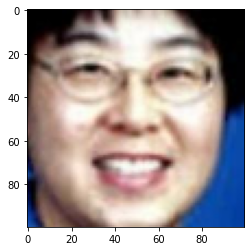

In [250]:
genders_list = ['male','female']
race_list = ['white','black','asian','indian','others']

img = np.expand_dims(test_generator[0][0][7], axis=0)
plt.imshow(test_generator[0][0][7])

p = model.predict(img)
print("gender: ",genders_list[np.argmax(p[0])])
print("race: ",race_list[np.argmax(p[1])])
print("age: ",int(p[2][0][0]))

### CONCLUSIONES

como se observo previamente el modelo no logra identificar muy bien a la etnia de las personas etiquetadas como OTROS, esto se debe a que hay pocas imagenes con esta etiqueta, si se desea mejorar el modelo lo mas recomendable es aumentar el numero de muestras para esta etiqueta.